# 0. Commentaire

### V2 Adaptation de la V1 sur train_V2

### V1 Sur base train_V1

Cette version semble fonctionner: je réussis à appeler un SK_ID dans l'API qui me renvoie les shap.values

=> modèle splitté en 3: 

    - la partie sampler (qui elle ne sembe pas s'appliquer => j'ai toujours 61498 lignes dans mon df shap values)
    - la partie transformer (transfromer2) = imputer + standard scaler
    - la partie estimateur (LogReg2)

=> A inclure dans P7_2_1 pour vérifier quele shap.base est identique dans l'onglet 'Shap_test' et dans l'onglet 'shap_val

### Remarque: différence entre .loc et .iloc dans le résultat affiché dans l'API

Ave iloc pas d'index affiché / Avec .loc index affiché suivi de : puis donnée souhaitée (impact ajout d'une couche de dictionnaire)

=> Tester le passage du SK_ID dans l'index...

In [2]:
pwd

'c:\\Users\\xavie\\P7\\P7_ML_model'

# 1 Intro

Adaptation best_lgcm pour appel shap_values dans API

## 1.1 Imports

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle
import shap

## 1.2 Fonctions utiles

In [4]:
from src.fonctions import result, print_score

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
DISPLAY=True

"""If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.
Else they will

This short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"""

"If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.\nElse they will\n\nThis short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"

# 2 Data

## 2.1 Import and display

In [7]:
train_V2=pd.read_csv('../train_V2.csv')

In [8]:
train_V2.shape

(307455, 31)

In [9]:
train_V2=train_V2.sample(frac=0.2)
train_V2.shape

(61491, 31)

# 3 Best model: best_lgbm

In [10]:
best_LGBM=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))
])
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))])

In [11]:
X=train_V2.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61491, 23)

In [12]:
y=train_V2['TARGET']
y.shape

(61491,)

Entraienemtnt via GridSearch

In [13]:
grid= GridSearchCV(
    best_LGBM,
    param_grid={},
    cv=10,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc'
    )

In [14]:
grid.fit(X,y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2893
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('estimator',
                                        LGBMClassifier(max_depth=3,
                                                       min_data_in_leaf=500,
                                                       num_leaves=20))]),
             n_jobs=-1, param_grid={}, refit='roc_auc', return_train_score=True,
             scoring=('roc_auc', 'accuracy', 'f1', 'recall', 'precision'),
             verbose=2)

In [15]:
res=result(grid, features='Sans_SK_ID_CURR')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,2.01,0.72,0.09,0.05,{},0.75,0.01,1,0.77,0.0,0.68,0.01,1,0.69,0.0,0.26,0.01,1,0.27,0.0,0.69,0.03,1,0.71,0.01,0.16,0.01,1,0.17,0.0,0,0,Sans_SK_ID_CURR


In [16]:
RES=pd.DataFrame()

In [17]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,2.01,0.72,0.09,0.05,{},0.75,0.01,1,0.77,0.0,0.68,0.01,1,0.69,0.0,0.26,0.01,1,0.27,0.0,0.69,0.03,1,0.71,0.01,0.16,0.01,1,0.17,0.0,0,0,Sans_SK_ID_CURR


# 4 Adpatation modèle pour appel SHAP dans l'API

Rappel: Shap ne prend que l'estimateur (et pas le pipeline entier) pour calculer explaienr/shap_values

Or en récupérant le best_lgbm, et en le décomposant, dans l'API je dois faire appel à l'Id des crédits/clients. Cet Id n'est pas utilisé dans le best_lgbml.

2 solutions:

- 1/ j'ajoute l'id dans le bet_model, au risque d'avoir des résultats un peu moins bons => partie 4.1
- 2/ Comme pour l'AMNT_GOOD_PRICE, je reconstitue le df après l'entrainement => partie 4.2


## 4.1 Ajout de SK_ID_CURR dans le modèle 

In [18]:
X2=train_V2.drop(['TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X2.shape

(61491, 24)

In [19]:
y2=y
y2.shape

(61491,)

In [20]:
grid= GridSearchCV(
    best_LGBM,
    param_grid={},
    cv=10,
    scoring=('roc_auc','accuracy','f1','recall','precision'),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [21]:
grid.fit(X2,y2)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 4989, number of negative: 4989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 9978, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('estimator',
                                        LGBMClassifier(max_depth=3,
                                                       min_data_in_leaf=500,
                                                       num_leaves=20))]),
             n_jobs=-1, param_grid={}, refit='roc_auc', return_train_score=True,
             scoring=('roc_auc', 'accuracy', 'f1', 'recall', 'precision'),
             verbose=2)

In [22]:
res=result(grid, features='Avec_SK_ID_CURR')
res.sort_values(by='mean_test_roc_auc',ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,8.25,5.5,0.08,0.03,{},0.75,0.01,1,0.77,0.0,0.68,0.01,1,0.69,0.0,0.26,0.01,1,0.27,0.0,0.69,0.02,1,0.71,0.0,0.16,0.01,1,0.17,0.0,0,0,Avec_SK_ID_CURR


In [23]:
RES=pd.concat([RES, res],axis=0, ignore_index=True)
RES

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,log_target,transf_feat,features
0,2.01,0.72,0.09,0.05,{},0.75,0.01,1,0.77,0.0,0.68,0.01,1,0.69,0.0,0.26,0.01,1,0.27,0.0,0.69,0.03,1,0.71,0.01,0.16,0.01,1,0.17,0.0,0,0,Sans_SK_ID_CURR
1,8.25,5.50,0.08,0.03,{},0.75,0.01,1,0.77,0.0,0.68,0.01,1,0.69,0.0,0.26,0.01,1,0.27,0.0,0.69,0.02,1,0.71,0.00,0.16,0.01,1,0.17,0.0,0,0,Avec_SK_ID_CURR


Résultats sensiblement identiques avec ou sans SK_ID_CURR

=> On peut ajouter l'id dans notre best_model sans diminuer la qualité du modèle

Enregistrment du modèle au format pkl pour utilisation dans l'API

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X2,y2,test_size=0.2)

In [25]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49192, 24)
Test set: (12299, 24)
Train target: (49192,)
Test target: (12299,)


In [26]:
best_LGBM.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 3974, number of negative: 3974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))])

In [27]:
lgbm_predict=best_LGBM.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


In [28]:
print_score(y_test, lgbm_predict)

Accuracy score = 0.6767216846898122
Precision score = 0.15847750865051904
Recall score = 0.6768472906403941
F1 score = 0.2568224299065421
ROC AUC score = 0.6767788385140998


Enregistrement de la partie preprocessing puis estimateur

In [29]:
best_LGBM[:-1]

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [30]:
best_LGBM[-1]

LGBMClassifier(max_depth=3, min_data_in_leaf=500, num_leaves=20)

In [28]:
#best_model[:-1]

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [29]:
#best_model[-1]

LogisticRegression()

Enregistrement de la partie preprocessing:
- sampler
- imputer
- scaler

In [31]:
pickle_out = open("transformerV2.pkl","wb")
pickle.dump(best_LGBM[:-1], pickle_out)
pickle_out.close()

Enregistrement de la partie estimateur

In [32]:
pickle_out = open("lgmbV2.pkl","wb")
pickle.dump(best_LGBM[-1], pickle_out)
pickle_out.close()

Essai...

In [33]:
TF=pd.DataFrame(best_LGBM[:-1].transform(X2),columns = X2.columns)
TF

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
0,-1.605567,-0.689893,0.667545,0.945382,-0.862377,-1.019255,-0.170796,-0.040521,0.550583,0.051492,-0.809093,-0.544767,0.203941,-0.428508,1.833551,-1.395365,-0.135692,1.690079,-0.850022,0.484045,0.29442,0.790796,-2.352910,0.615746
1,-1.417408,1.449501,-1.498026,-0.575111,-0.814491,-0.438939,0.913457,-0.529205,0.325285,0.012892,1.708852,1.260225,0.575865,2.333681,0.067336,0.021613,1.053024,-0.922690,0.733204,-0.788319,0.29442,-1.264549,0.425006,0.615746
2,-0.225143,-0.689893,0.667545,-1.072004,-1.022318,-0.570213,-1.255048,2.863444,0.087489,1.763644,-0.022236,-0.377012,-0.663881,-0.428508,-0.131556,1.052713,2.075150,2.111494,-0.850022,-0.352578,0.29442,0.790796,-2.352910,-1.624047
3,-1.451765,1.449501,-1.498026,1.164015,0.262952,1.644577,0.913457,-0.040521,0.144319,-0.365667,2.180966,2.582697,1.071763,-0.428508,0.016247,-0.013553,0.849317,0.004422,-0.322280,-0.025772,0.29442,-1.264549,0.425006,0.615746
4,-0.223942,1.449501,0.667545,0.170229,-1.102527,-1.119446,-0.170796,-0.040521,-1.186152,-0.429886,0.764622,-0.081891,1.264613,-0.428508,2.201725,-1.261031,0.801672,0.257271,-0.498194,-0.025772,0.29442,-1.264549,0.425006,0.615746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61486,0.606240,1.449501,0.667545,1.909355,2.544222,1.949450,0.913457,1.983875,1.082765,0.677694,0.135136,1.475348,1.505675,-0.428508,-0.534815,-0.269739,-0.906090,1.100099,4.603311,0.301034,0.29442,0.790796,0.425006,0.615746
61487,1.460533,-0.689893,0.667545,-0.972625,-1.033427,-1.173014,-0.170796,-0.040521,-0.586195,0.051492,-0.809093,-0.544767,-0.663881,-0.428508,0.039411,-0.435864,0.164453,1.015816,3.020085,-0.777426,0.29442,0.790796,0.425006,0.615746
61488,0.383123,1.449501,0.667545,-0.426043,-0.520433,-0.780184,-0.170796,-0.040521,0.852840,0.051492,-0.809093,-0.544767,-0.663881,-0.428508,-0.194911,-0.579547,-0.544161,1.184382,-0.498194,-0.417939,0.29442,0.790796,0.425006,0.615746
61489,0.919548,-0.689893,0.667545,13.089449,-0.000231,0.084503,-0.170796,0.777849,0.645015,-0.511284,-0.809093,-0.544767,-0.663881,-0.428508,5.973588,-1.725722,-0.270944,0.341553,-0.498194,8.471183,0.29442,-1.264549,0.425006,0.615746


Pb: le SK_ID_CURR est scalé

In [36]:
explainer=shap.TreeExplainer(best_LGBM[-1])#,TF)

In [37]:
shap_values=explainer.shap_values(TF)

In [38]:
type(shap_values)

list

In [40]:
#shap.plots.bar(shap_values[0])

In [45]:
#shap_values[0]

In [48]:
#tmp=pd.DataFrame(shap_values.base_values)
#tmp

Valeurs d'origne de SKIDCURR

In [51]:
best_LGBM[-2]

StandardScaler()

In [52]:
TF['SK_ID_CURR']

0       -1.605567
1       -1.417408
2       -0.225143
3       -1.451765
4       -0.223942
           ...   
61486    0.606240
61487    1.460533
61488    0.383123
61489    0.919548
61490    1.408872
Name: SK_ID_CURR, Length: 61491, dtype: float64

In [55]:
#TF['SK_ID_CURR'] = best_LGBM[-2].inverse_transform(TF['SK_ID_CURR'])
#TF

In [56]:
id_sca=type(TF.SK_ID_CURR).to_numpy(self=TF.SK_ID_CURR)
id_sca.shape

(61491,)

In [59]:
#id_orig=best_LGBM[-2].inverse_transform(id_sca)
#id_orig

## 4.2 Ajout de SK_ID_CURR après entrainement de best_model

X: df sans SK_ID

X2: df avec SK_ID

Train test split sur base X2

In [60]:
X2

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
9587,111143,0,1,250200.0,252000.0,12996.0,2.0,NaN,0.579227,NaN,0.0,0.000,0.200000,0.0,0.992857,0.051942,0.051571,62,-0.0,125100.0,1,1,0,1
26285,130574,1,0,112500.0,270000.0,20893.5,3.0,0.368870,0.532266,0.459690,16.0,4861200.465,0.285714,1.0,0.416667,0.185720,0.077383,31,9.0,37500.0,1,0,1,1
132491,253698,0,1,67500.0,191880.0,19107.0,1.0,0.847899,0.482701,0.785052,5.0,451795.500,0.000000,0.0,0.351782,0.283067,0.099578,67,-0.0,67500.0,1,1,0,0
23225,127026,1,0,270000.0,675000.0,49248.0,3.0,NaN,0.494546,0.389339,19.0,8422879.500,0.400000,0.0,0.400000,0.182400,0.072960,42,3.0,90000.0,1,0,1,1
132600,253822,1,1,180000.0,161730.0,11632.5,2.0,NaN,0.217225,0.377404,10.0,1246617.000,0.444444,0.0,1.112966,0.064625,0.071925,45,2.0,90000.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206635,339554,1,1,337500.0,1532506.5,53397.0,3.0,0.723707,0.690155,0.583238,6.0,5440567.500,0.500000,0.0,0.220227,0.158213,0.034843,55,31.0,112500.0,1,1,1,1
282931,427776,0,1,76500.0,187704.0,10903.5,2.0,NaN,0.342279,NaN,0.0,0.000,0.000000,0.0,0.407557,0.142529,0.058089,54,22.0,38250.0,1,1,1,1
186728,316513,1,1,126000.0,380533.5,16249.5,2.0,NaN,0.642229,NaN,0.0,0.000,0.000000,0.0,0.331114,0.128964,0.042702,56,2.0,63000.0,1,1,1,1
234682,371909,0,1,1350000.0,576072.0,28017.0,2.0,0.553421,0.598911,0.362277,0.0,0.000,0.000000,0.0,2.343457,0.020753,0.048635,46,2.0,675000.0,1,0,1,1


In [61]:
X_train,X_test,y_train,y_test=train_test_split(X2,y2,test_size=0.2)

In [62]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49192, 24)
Test set: (12299, 24)
Train target: (49192,)
Test target: (12299,)


Decomposition du best_lgm

In [63]:
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))])

In [66]:
 #Sampling 
X_train_rus, y_train_rus=best_LGBM[0].fit_resample(X_train,y_train)

In [67]:
X_train_rus.shape

(8006, 24)

In [68]:
# Fill Nan with simple imputer
X_tr=pd.DataFrame(best_LGBM[1].fit_transform(X_train_rus),columns=X_train_rus.columns)
X_tr.shape

(8006, 24)

In [70]:
X_tmp=X_tr.drop(['SK_ID_CURR'],axis=1)
X_tmp.shape

(8006, 23)

In [52]:
#X_tr=best_model[1:-1].fit_transform(X_tmp)

In [64]:
best_LGBM[2]

StandardScaler()

In [72]:
# Scaling
X_tr_transf=pd.DataFrame(best_LGBM[2].fit_transform(X_tmp), columns=X_tmp.columns)
X_tr_transf.shape

(8006, 23)

In [73]:
X_tr_transf.isna().sum()

FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
AMT_INCOME_TOTAL       0
AMT_CREDIT             0
AMT_ANNUITY            0
CNT_FAM_MEMBERS        0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
Prev_contract_nb       0
Prev_AMT_CREDIT        0
Refused_rate           0
default_payment        0
INCOME_CREDIT_PERC     0
ANNUITY_INCOME_PERC    0
PAYMENT_RATE           0
client_age             0
client_prof_exp        0
INCOME_PER_PERSON      0
Cash_loans             0
GENDER_FEMALE          0
active_client          0
relationship           0
dtype: int64

In [75]:
# Entrainement
best_LGBM[-1].fit(X_tr_transf,y_train_rus)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 4003, number of negative: 4003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 8006, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

LGBMClassifier(max_depth=3, min_data_in_leaf=500, num_leaves=20)

Décompostion du modèle en 3 étape:

-> Random Under Sampling

-> Imputer + Scaler

-> LogReg()

In [81]:
best_LGBM[:-2]

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median'))])

In [80]:
best_LGBM[-2]

StandardScaler()

In [82]:
pickle_out = open("samplerV2.pkl","wb")
pickle.dump(best_LGBM[:-2], pickle_out)
pickle_out.close()

In [83]:
pickle_out = open("transformer2_V2.pkl","wb")
pickle.dump(best_LGBM[-2], pickle_out)
pickle_out.close()

In [84]:
pickle_out = open("logreg2_V2.pkl","wb")
pickle.dump(best_LGBM[-1], pickle_out)
pickle_out.close()

Test API:

In [62]:
transf_data = pd.DataFrame(sampler.transform(filtered_data),columns = filtered_data.columns) # fit_resample necessite (X,y)
    data_for_shap=transf_data.drop(['SK_ID_CURR'],axis=1)
    data_for_shap_tr=pd.DataFrame(transformer2.transform(data_for_shap),columns=data_for_shap.columns)
    explainer=shap.LinearExplainer(estimator2,data_for_shap_tr)
    shap_values=explainer(data_for_shap_tr)
    
    svv=pd.DataFrame(shap_values.values, columns = data_for_shap.columns).round(2)
    svv['SK_ID_CURR']=transf_data['SK_ID_CURR']
    svd=pd.DataFrame(shap_values.data, columns = data_for_shap.columns).round(2)
    svd['SK_ID_CURR']=transf_data['SK_ID_CURR']
    svb=pd.DataFrame(shap_values.base_values).round(2)

IndentationError: unexpected indent (1359803692.py, line 2)

In [63]:
transf_data = pd.DataFrame(best_model[:-2].transform(X2),columns = X2.columns) # fit_resample necessite (X,y)

In [64]:
transf_data.shape

(61498, 16)

In [65]:
data_for_shap=transf_data.drop(['SK_ID_CURR'],axis=1)

In [66]:
data_for_shap_tr=pd.DataFrame(best_model[-2].transform(data_for_shap),columns=data_for_shap.columns)

In [67]:
explainer=shap.LinearExplainer(best_model[-1],data_for_shap_tr)

In [68]:
shap_values=explainer(data_for_shap_tr)

In [69]:
svv=pd.DataFrame(shap_values.values, columns = data_for_shap.columns).round(2)
svv

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship
0,-0.19,-0.04,-0.01,-0.00,0.01,-0.01,0.05,-0.56,-0.10,-0.08,-0.04,0.03,0.21,0.11,-0.05
1,0.09,0.02,0.03,0.02,-0.03,-0.01,0.05,0.38,0.42,0.09,0.17,0.03,-0.11,-0.61,-0.05
2,0.09,0.02,0.05,-0.01,-0.03,-0.07,0.05,-0.56,-0.76,0.05,-0.00,0.03,-0.11,0.11,0.13
3,0.09,0.02,-0.01,0.01,-0.02,0.05,-0.45,-0.49,-0.51,0.01,-0.21,0.03,-0.11,0.11,-0.05
4,0.09,0.02,-0.05,0.01,-0.01,-0.07,0.05,-0.45,0.05,0.05,0.13,0.03,-0.11,0.11,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61493,0.09,0.02,0.02,-0.07,0.02,0.05,0.05,0.37,-0.97,-0.03,-0.25,0.03,0.21,0.11,-0.05
61494,0.09,0.02,0.02,0.05,-0.05,-0.01,0.05,0.55,-0.35,0.08,0.17,0.03,-0.11,-0.61,-0.05
61495,0.09,0.02,0.03,-0.08,0.16,-0.01,0.05,-0.56,-0.83,0.12,0.17,0.03,-0.11,-0.61,-0.05
61496,0.09,-0.04,-0.17,-0.04,0.02,0.17,-0.11,0.18,-0.32,-0.00,-0.04,0.03,0.21,0.11,-0.05


In [70]:
svv['SK_ID_CURR']=transf_data['SK_ID_CURR']
svv

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_age,client_prof_exp,Cash_loans,GENDER_FEMALE,active_client,relationship,SK_ID_CURR
0,-0.19,-0.04,-0.01,-0.00,0.01,-0.01,0.05,-0.56,-0.10,-0.08,-0.04,0.03,0.21,0.11,-0.05,351895.0
1,0.09,0.02,0.03,0.02,-0.03,-0.01,0.05,0.38,0.42,0.09,0.17,0.03,-0.11,-0.61,-0.05,381608.0
2,0.09,0.02,0.05,-0.01,-0.03,-0.07,0.05,-0.56,-0.76,0.05,-0.00,0.03,-0.11,0.11,0.13,409120.0
3,0.09,0.02,-0.01,0.01,-0.02,0.05,-0.45,-0.49,-0.51,0.01,-0.21,0.03,-0.11,0.11,-0.05,221618.0
4,0.09,0.02,-0.05,0.01,-0.01,-0.07,0.05,-0.45,0.05,0.05,0.13,0.03,-0.11,0.11,0.13,189802.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61493,0.09,0.02,0.02,-0.07,0.02,0.05,0.05,0.37,-0.97,-0.03,-0.25,0.03,0.21,0.11,-0.05,119280.0
61494,0.09,0.02,0.02,0.05,-0.05,-0.01,0.05,0.55,-0.35,0.08,0.17,0.03,-0.11,-0.61,-0.05,213899.0
61495,0.09,0.02,0.03,-0.08,0.16,-0.01,0.05,-0.56,-0.83,0.12,0.17,0.03,-0.11,-0.61,-0.05,290869.0
61496,0.09,-0.04,-0.17,-0.04,0.02,0.17,-0.11,0.18,-0.32,-0.00,-0.04,0.03,0.21,0.11,-0.05,101228.0


In [71]:
shap_values[62000]

IndexError: index 62000 is out of bounds for axis 0 with size 61498

In [90]:
type(shap_values)

shap._explanation.Explanation

In [81]:
shap_values[0]

.values =
array([-1.87973890e-01, -4.00616298e-02, -1.26609466e-02, -6.03522468e-05,
        6.13003661e-03, -8.27922236e-03,  4.84500337e-02, -5.56707210e-01,
       -1.03666850e-01, -8.38350722e-02, -3.97042832e-02,  2.66822754e-02,
        2.08322769e-01,  1.07251423e-01, -4.64317117e-02])

.base_values =
-0.19579387944436355

.data =
array([ 1.43508025, -1.48649183,  0.26268381,  0.0840153 ,  0.19893256,
       -0.16225315, -0.04313659,  1.17022907,  0.32642423, -1.24928899,
        0.20050707,  0.30085104, -1.27899291,  0.43007568,  0.60980409])

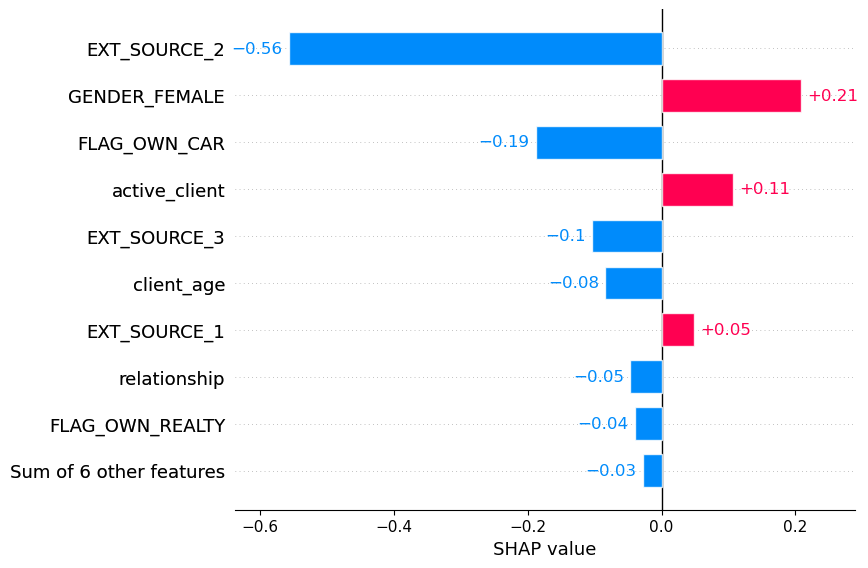

In [100]:
shap.plots.bar(shap_values[0])

In [102]:
exp.feature_names

In [94]:
type(shap_values)

shap._explanation.Explanation

In [98]:
shap_values.cohorts

<bound method Explanation.cohorts of .values =
array([[-0.18797389, -0.04006163, -0.01266095, ...,  0.20832277,
         0.10725142, -0.04643171],
       [ 0.0884583 ,  0.02063781,  0.0260153 , ..., -0.10731779,
        -0.60775806, -0.04643171],
       [ 0.0884583 ,  0.02063781,  0.04811602, ..., -0.10731779,
         0.10725142,  0.12553759],
       ...,
       [ 0.0884583 ,  0.02063781,  0.03430307, ..., -0.10731779,
        -0.60775806, -0.04643171],
       [ 0.0884583 , -0.04006163, -0.17289112, ...,  0.20832277,
         0.10725142, -0.04643171],
       [-0.18797389,  0.02063781, -0.00161059, ..., -0.10731779,
         0.10725142,  0.12553759]])

.base_values =
array([-0.19579388, -0.19579388, -0.19579388, ..., -0.19579388,
       -0.19579388, -0.19579388])

.data =
array([[ 1.43508025, -1.48649183,  0.26268381, ..., -1.27899291,
         0.43007568,  0.60980409],
       [-0.69682514,  0.67272486, -0.43124586, ...,  0.78186516,
        -2.32517219,  0.60980409],
       [-0.696825

In [103]:
v1=shap_values.values
v2=shap_values.base_values
v3=shap_values.data
v4=shap_values.feature_names
#v = np.concatenate((v1, v2, v3))

In [108]:
exp=shap.Explanation(v1,feature_names=v4) #v2,v4)

In [109]:
type(exp)

shap._explanation.Explanation

In [110]:
exp.cohorts

<bound method Explanation.cohorts of .values =
array([[-0.18797389, -0.04006163, -0.01266095, ...,  0.20832277,
         0.10725142, -0.04643171],
       [ 0.0884583 ,  0.02063781,  0.0260153 , ..., -0.10731779,
        -0.60775806, -0.04643171],
       [ 0.0884583 ,  0.02063781,  0.04811602, ..., -0.10731779,
         0.10725142,  0.12553759],
       ...,
       [ 0.0884583 ,  0.02063781,  0.03430307, ..., -0.10731779,
        -0.60775806, -0.04643171],
       [ 0.0884583 , -0.04006163, -0.17289112, ...,  0.20832277,
         0.10725142, -0.04643171],
       [-0.18797389,  0.02063781, -0.00161059, ..., -0.10731779,
         0.10725142,  0.12553759]])>

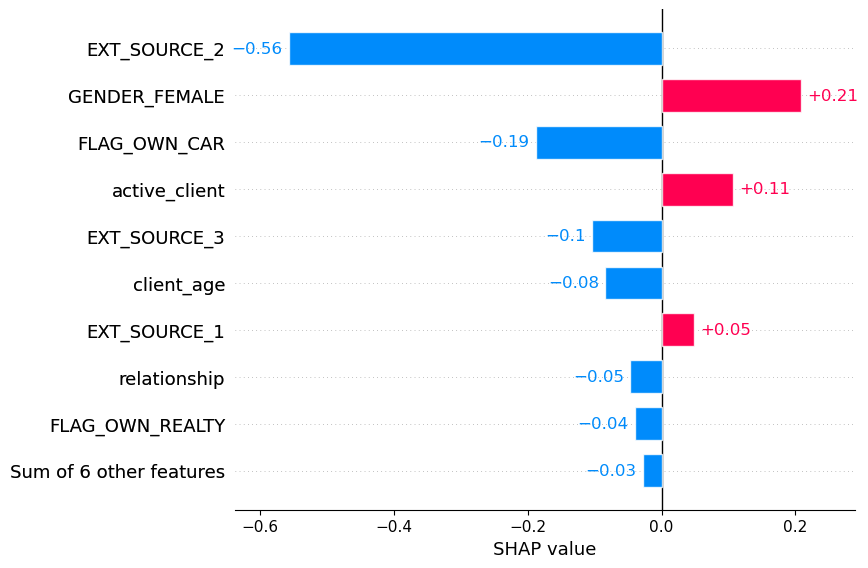

In [111]:
shap.plots.bar(exp[0])

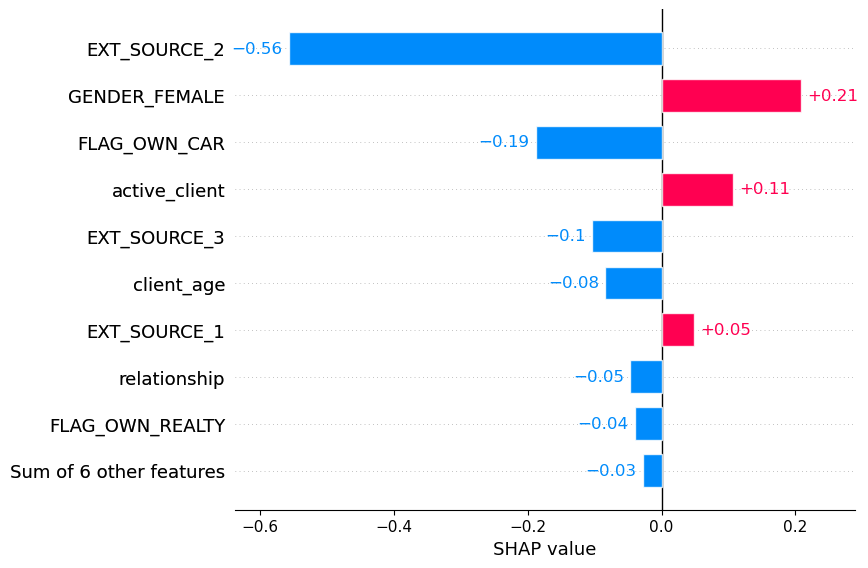

In [112]:
shap.plots.bar(shap_values[0])

In [93]:
type(v1)

numpy.ndarray

In [89]:
v=v.to_dict()

AttributeError: 'numpy.ndarray' object has no attribute 'to_dict'